### Performance Discovery Notebook

This notebook takes as input 2 evergreen mainline builds, and outputs an interactive data grid laying out the performance divergences between the two. 

The current comparison equation as recommended by the release management:

<left> <b>percent</b> = $  100 \times \LARGE \left ( \frac{y_{rc} - \bar{y}}{\bar{y}} \right ) $ </left>
<br>
<left><b>z_score</b> = $ \LARGE \frac{y_{rc} - \bar{y}}{\sigma_y} $ </left>

where $\large \bar{y} $ and $ \large \sigma_y $ refer to the mean and standard deviation since the last <b>Change Point</b>.
    
To Do:
- Pick the limits - run on different branches over the next few releases
    - abs(percent) > 25% | abs(z_score) > 2
- Understand the new metrics
    - system cpu user (%) - mean
    - ss mem resident (MiB) - mean
    - Data - disk xvde utilization (%) - mean
    - Journal - disk xvdf utilization (%) - mean


In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from more_itertools import pairwise
import re
import requests
import json
import yaml
import os
from jupyter_datatables import init_datatables_mode

from nblib import data, perfdisclib

In [2]:
max_tasks=4000
max_tests=20000
batch=100

build_a = "sys_perf_4.4_abb6b9c2bf675e9e2aeaecba05f0f8359d99e203" 
build_a_label = '4.4.7'
build_b = "sys_perf_4.4_83b8bb8b6b325d8d8d3dfd2ad9f744bdad7d6ca0"
build_b_label = '4.4.8'

client = data.PerfAtlasClient().conn()

In [3]:
perf_disc_info = perfdisclib.Info(client=client, max_tasks=max_tasks, max_tests=max_tests, batch=batch, build_a=build_a, build_a_label=build_a_label, build_b=build_b, build_b_label=build_b_label)
perf_disc_analysis = perfdisclib.Analysis(perf_disc_info)

In [4]:
%%time

# Get the list of tasks from the 2 commits.

dfa = perf_disc_analysis.read_task_list(perf_disc_analysis.pd_info.build_a)
dfb = perf_disc_analysis.read_task_list(perf_disc_analysis.pd_info.build_b)

Fetching tasks for sys_perf_4.4_abb6b9c2bf675e9e2aeaecba05f0f8359d99e203
Tasks fetched: 4000
Finished fetching tasks
Fetching tasks for sys_perf_4.4_83b8bb8b6b325d8d8d3dfd2ad9f744bdad7d6ca0
Tasks fetched: 4000
Finished fetching tasks
CPU times: user 1.65 s, sys: 272 ms, total: 1.92 s
Wall time: 4.91 s


In [5]:
%%time

comparison, found_ts = perf_disc_analysis.filter_and_merge(dfa, dfb)

dfa length = 40859, dfb length = 44270
filtered dfa length = 35323, filtered dfb length = 38354
length of merged comparison = 24719
length after de-dup = 22550
length after keeping interesting metrics = 1756
CPU times: user 346 ms, sys: 3.62 ms, total: 349 ms
Wall time: 346 ms


In [6]:
%%time

found_ts, date_a, date_b = perf_disc_analysis.process_stable_regions(found_ts)

Stable regions processed: 1756/1756
CPU times: user 3 s, sys: 406 ms, total: 3.41 s
Wall time: 5.73 s


In [9]:
# merge the results together:
comparison = comparison.merge(found_ts, on=["project","variant","task","test","measurement","args"])

#comparison["difference"] = comparison["value_y"] - comparison["value_x"]
#comparison["percentage_change"] = ((comparison["value_y"] / comparison["value_x"]) * 100) - 100
#comparison["difference_from_stable_mean"] = comparison["value_y"] - comparison["stable_mean"]
comparison["percent"] = ((comparison["value_y"] / (1.E-3+comparison["stable_mean"])) * 100) - 100
comparison["z_score"] = (comparison["value_y"] - comparison["stable_mean"]) / (1.E-3+comparison["stable_std"])

In [10]:
# save the data to CSV
with open("compare.csv", "w") as csv:
    comparison.to_csv(csv)
    

array([[<AxesSubplot:title={'center':'AverageLatency'}>,
        <AxesSubplot:title={'center':'Data - disk xvde utilization (%) - mean'}>],
       [<AxesSubplot:title={'center':'Journal - disk xvdf utilization (%) - mean'}>,
        <AxesSubplot:title={'center':'ops_per_sec'}>],
       [<AxesSubplot:title={'center':'ss mem resident (MiB) - mean'}>,
        <AxesSubplot:title={'center':'system cpu user (%) - mean'}>]],
      dtype=object)

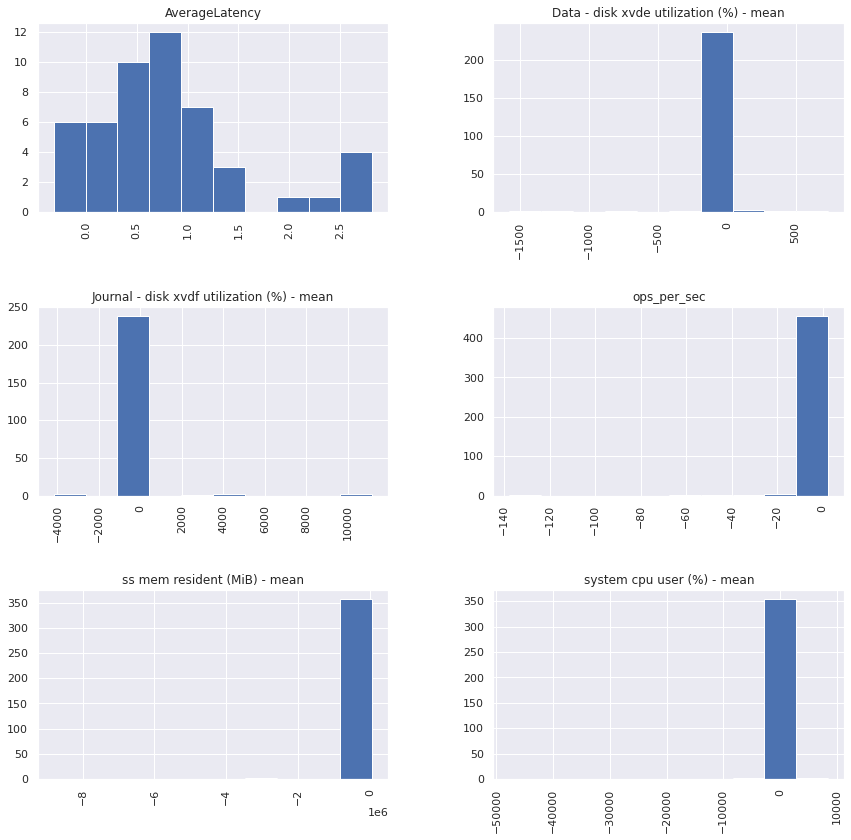

In [11]:
# histogram the Zscores
%matplotlib inline

import seaborn as sns
sns.set_theme()

plt.rcParams["figure.figsize"] = (14,14)

comparison["z_score"].hist(by=comparison["measurement"])


array([[<AxesSubplot:title={'center':'AverageLatency'}>,
        <AxesSubplot:title={'center':'Data - disk xvde utilization (%) - mean'}>],
       [<AxesSubplot:title={'center':'Journal - disk xvdf utilization (%) - mean'}>,
        <AxesSubplot:title={'center':'ops_per_sec'}>],
       [<AxesSubplot:title={'center':'ss mem resident (MiB) - mean'}>,
        <AxesSubplot:title={'center':'system cpu user (%) - mean'}>]],
      dtype=object)

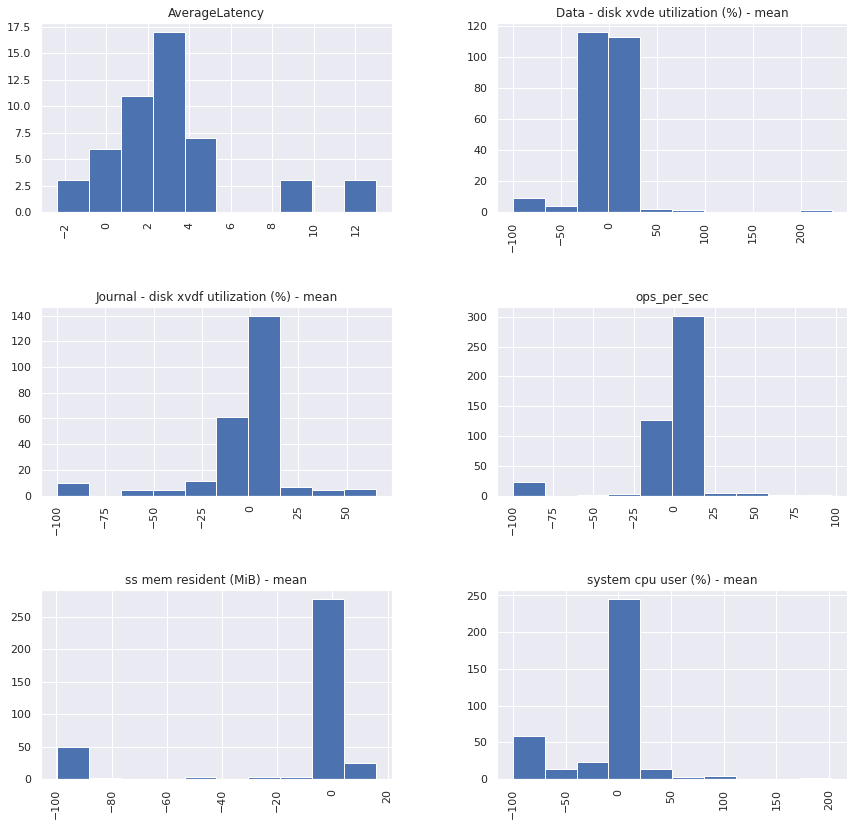

In [12]:
# histogram the % changes
%matplotlib inline

import seaborn as sns
sns.set_theme()

plt.rcParams["figure.figsize"] = (14,14)

comparison["percent"].hist(by=comparison["measurement"])

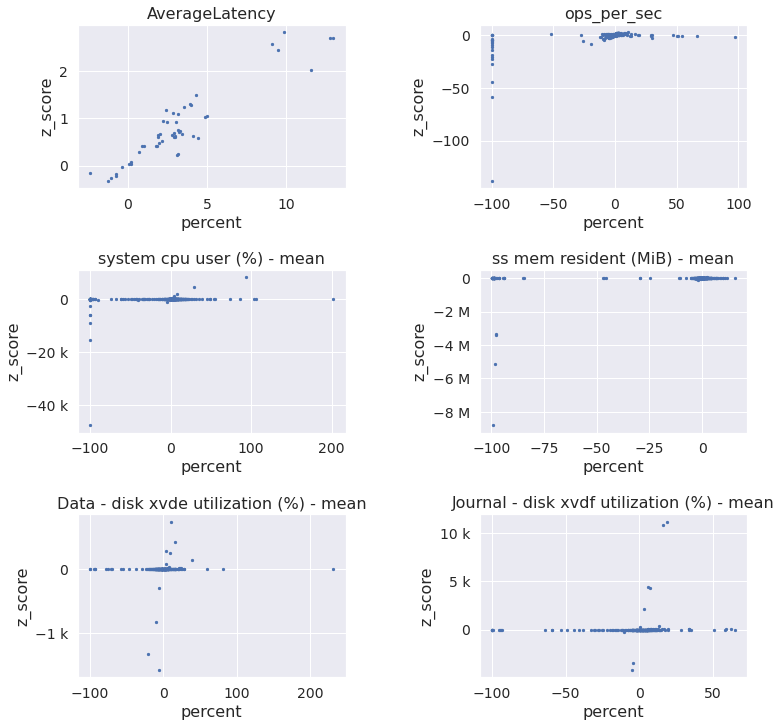

In [13]:
# scatter plots 

# %matplotlib widget
# %matplotlib ipympl

# %matplotlib inline
# loses Engineering format
# import mpld3
# mpld3.enable_notebook()
from matplotlib.ticker import EngFormatter

params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize':14,
         'ytick.labelsize':14
         }
plt.rcParams.update(params)

fig, axs = plt.subplots(3,2, figsize=(12,12))
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
i=0
for t in ['AverageLatency',
'ops_per_sec',
'system cpu user (%) - mean',
'ss mem resident (MiB) - mean',
'Data - disk xvde utilization (%) - mean',
'Journal - disk xvdf utilization (%) - mean']:
    axs[i].yaxis.set_major_formatter(EngFormatter()) 
    axs[i].set_title(t)
    axs[i].set(xlabel="percent", ylabel="z_score")
    axs[i].scatter(comparison["percent"][(comparison["measurement"] == t)],
             comparison["z_score"][(comparison["measurement"] == t)], s=5)
    i=i+1
    



In [14]:
def plot_timeseries(row_num):
    
    # put chart on a new pop-up    
    from IPython import get_ipython
    # %matplotlib widget
    %matplotlib qt

    project = comparison.loc[row_num, 'project']
    variant = comparison.loc[row_num, 'variant']
    task = comparison.loc[row_num, 'task']
    test = comparison.loc[row_num, 'test']
    measurement = comparison.loc[row_num, 'measurement']    
    args = comparison.loc[row_num, 'args']
    value_x = comparison.loc[row_num, 'value_x']
    value_y = comparison.loc[row_num, 'value_y']
    z_score = comparison.loc[row_num, 'z_score']
    percent = comparison.loc[row_num, 'percent']
    stable_mean = comparison.loc[row_num, 'stable_mean']
    stable_std = comparison.loc[row_num, 'stable_std']

    time_series = client["expanded_metrics"]["time_series"].find_one(
        { "project": project,
          "variant": variant, 
          "test": test, 
          "task": task, 
          "measurement": measurement,
         "args": json.loads(args)
        }
    )
        
    dates = [time_series_point["commit_date"] for time_series_point in time_series["data"]]
    values = [time_series_point["value"] for time_series_point in time_series["data"]]

    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 6),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':10,
         'ytick.labelsize':18}
    plt.rcParams.update(params)

    plt.suptitle(variant+' '+task+' '+test, fontsize=16)
    plt.title("z_score = {:.2f}".format(z_score)+"  percent = {:.2f}".format(percent), fontsize=10, loc='left')
    plt.plot(dates, values)
    
    plt.xlabel("Commit Date")
    plt.ylabel(time_series["measurement"])
    
    # add marks for the commits
    plt.axvline(date_a, color="green", linestyle="dotted")
    plt.text(date_a, value_x, build_a_label, rotation=90, fontsize=20)
    plt.axhline(value_x, color="green", linestyle="dotted" )
    plt.axvline(date_b, color="red", linestyle="dashed")
    plt.text(date_b, value_y, build_b_label, rotation=90, fontsize=20)
    plt.axhline(value_y, color="red", linestyle="dashed" )
    plt.axhline(stable_mean, color="purple", linestyle="dashdot" )
    plt.axhspan(stable_mean-stable_std, stable_mean+stable_std, facecolor="purple", alpha=0.05)
    
    plt.show()
    

In [17]:
# print the table as a qgrid

# increase size of output window
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 48em; }</style>"))

comparison = comparison.sort_values(by=['z_score', 'percent'], ignore_index=True)

df = pd.DataFrame(comparison)

pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 20)
pd.options.display.float_format = '{:.2f}'.format
# qgrid floating format
pd.set_option('display.precision', 3)

# add filter here to remove ok looking z_score & percentage differences

ddf = df[[ 'variant', 'task', 'test', 'measurement',  'z_score', 'percent', 
          'value_x', 'value_y', 'stable_mean', 'stable_length', 'stable_std', 'args']]

# save to disk
with open(f"selected_tasks_{build_a_label}_{build_b_label}.csv", "w") as csv:
    ddf.to_csv(csv)
    
import ipydatagrid

info_grid = ipydatagrid.DataGrid(ddf, selection_mode="row")

# display plot when row is selected
def on_row_selected(change):
    print("hello")
    plot_timeseries(change.new[0])
    
info_grid.observe(on_row_selected, names=['_selected_rows'])

print('Click on a row to see the time-series')
info_grid

Click on a row to see the time-series


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…